# Importing libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd drive/MyDrive/colab_projects/image-classification/

[Errno 2] No such file or directory: 'drive/MyDrive/colab_projects/image-classification/'
/content/drive/MyDrive/colab_projects/image-classification


In [2]:
import os
import tensorflow as tf
import tensorflow.keras.models as models
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import metrics
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [3]:
print(tf.__version__)

2.11.0


In [4]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

# Input Data

### Paths

In [5]:
train_data_path = "/content/drive/MyDrive/Colab Notebooks/Project/Multi classifacation/Data/Train"

In [6]:
validation_data_path = "/content/drive/MyDrive/Colab Notebooks/Project/Multi classifacation/Data/Val"

### Train and validation image data generator

We also implement image augumentation for training images. This will help reduce overfitting

In [7]:
## Initializing Training ImageDataGenerator class with various augumentation params
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

In [8]:
## defining batch size and the image shape and specifying the source path
## the labels are automaotically built from the folder name in the directory

train_generator = train_datagen.flow_from_directory(train_data_path, 
                                                    batch_size =32,
                                                    class_mode = 'categorical',
                                                    target_size = (224,224),
                                                    seed=99)

Found 4000 images belonging to 10 classes.


In [9]:
## initialzing validation imagedatagenerator class with only rescale param. Others are kept at default
validation_datagen = ImageDataGenerator(rescale=1./255.)

In [10]:
validation_generator = validation_datagen.flow_from_directory(validation_data_path,shuffle=False,
                                                              batch_size = 32,
                                                              class_mode = 'categorical',
                                                              target_size = (224, 224))

Found 500 images belonging to 10 classes.


In [11]:
training_data_df = pd.DataFrame(data={"file":train_generator.filepaths,
                                      "labels": train_generator.labels})

In [12]:
training_data_df.sample()

,file,labels
757,/content/drive/MyDrive/Colab Notebooks/Project...,1


### Visualizing training data

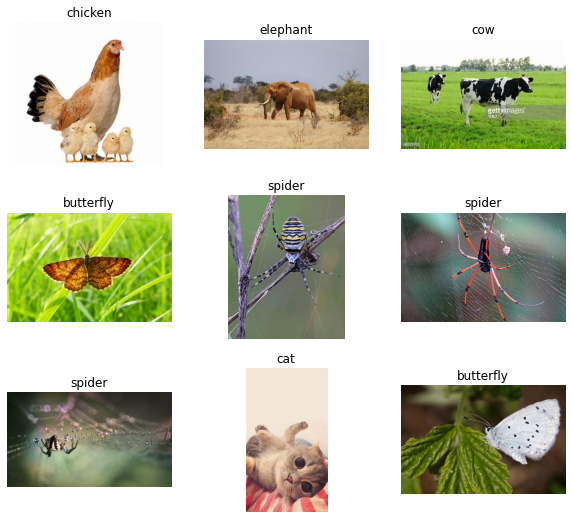

In [13]:
## visualizing some training data
sample_training_data = training_data_df.sample(10)
sample_training_data.reset_index(drop=True, inplace=True)
label_mapping = {0:"dog", 1:"horse", 2:"elephant", 3:"butterfly", 4:"chicken", 5:"cat", 6:"cow", 7:"sheep", 8:"spider", 9:"squirrel"}

plt.figure(figsize=(10,9))
for i in range(9):
  plt.subplot(3, 3, i + 1)
  plt.imshow(mpimg.imread(sample_training_data.iloc[i]['file']))
  plt.title(label_mapping[sample_training_data.iloc[i]['labels']])
  plt.axis("off")

# Model Training

In [14]:
def get_pre_trained_model_inception():

  from tensorflow.keras.applications.inception_v3 import InceptionV3

  try:
    
    ## Transfer Learning
    model = InceptionV3(include_top=False,
                            input_shape=(224, 224, 3),
                            weights='imagenet'
                            )
  
   
  except:
    print("Initializing pre-trained model failed !!")

  # freezing the pretrained model weights so that they wont be updated during back propagation
  for layer in model.layers:
    layer.trainable = False

  last_layer = model.get_layer("mixed7")
  last_output = last_layer.output

  return model, last_output

In [ ]:
def get_pre_trained_model_resnet():
  from tensorflow.keras.applications.resnet50 import ResNet50

  model = ResNet50(include_top=False, weights = 'imagenet', input_shape=(150,150,3))
  
  for layer in model.layers:
    layer.trainable = False
    # model.summary()
  output = model.layers[-1].output

  return model, output

In [15]:
def get_optimizer(optimizer_name="adam", lr=0.0001):

    # preparing optimizer
    if optimizer_name == "adam":
        optimizer = Adam(learning_rate=lr)
    elif optimizer_name == "rmsprop":
        optimizer = RMSprop(learning_rate=lr)

    return optimizer

In [16]:
def define_model(model="inception", learning_rate = 0.000001):
 

  # change this as per the experiment
  if model == 'inception':
    model, last_output = get_pre_trained_model_inception() 
  elif model == 'resnet':
    model, last_output = get_pre_trained_model_resnet()

  ## Adding layers on top of the pretrained model

  ## flattening the convoultion output
  x = layers.Flatten()(last_output)
  # adding fully connected layer
  x = layers.Dense(1024, activation='relu')(x)
  # Dropout layer for regularization
  x = layers.Dropout(0.2)(x)
  # sigmoid layer for final prediction
  x = layers.Dense(10, activation='softmax')(x)
  model = models.Model(model.input, x)

  optimizer = get_optimizer(lr=learning_rate)

  # model compilation
  model.compile(optimizer=optimizer,
                  loss = 'CategoricalCrossentropy',
                  metrics = ['accuracy'])
  
  return model

In [17]:
def get_callbacks():
  """
  returns a list of callback functions
  """
  ## earlystopping to prevent overfitting
  from tensorflow.keras.callbacks import EarlyStopping
  es_callback = EarlyStopping(monitor='val_loss', patience=5)

  return [es_callback]



In [ ]:
def fit_model(model='inception',lr=0.001):

  model = define_model(model=model,learning_rate=lr)

  callbacks = get_callbacks()

  history = model.fit(train_generator,
                       validation_data = validation_generator,
                       epochs = 20,
                       steps_per_epoch =None,
                       validation_steps = None,
                       verbose = 1,
                      callbacks= callbacks)
  
  return history, model

In [ ]:
history, model = fit_model()

Epoch 1/20
125/125 [==============================] - 1765s 14s/step - loss: 2.3396 - accuracy: 0.6837 - val_loss: 0.3149 - val_accuracy: 0.8940
Epoch 2/20
125/125 [==============================] - 74s 594ms/step - loss: 0.4961 - accuracy: 0.8382 - val_loss: 0.2268 - val_accuracy: 0.9240
Epoch 3/20
125/125 [==============================] - 74s 595ms/step - loss: 0.4067 - accuracy: 0.8627 - val_loss: 0.1959 - val_accuracy: 0.9360
Epoch 4/20
125/125 [==============================] - 77s 614ms/step - loss: 0.3365 - accuracy: 0.8870 - val_loss: 0.2587 - val_accuracy: 0.9160
Epoch 5/20
125/125 [==============================] - 75s 601ms/step - loss: 0.3656 - accuracy: 0.8788 - val_loss: 0.1793 - val_accuracy: 0.9360
Epoch 6/20
125/125 [==============================] - 76s 609ms/step - loss: 0.3128 - accuracy: 0.8898 - val_loss: 0.1610 - val_accuracy: 0.9480
Epoch 7/20
125/125 [==============================] - 74s 591ms/step - loss: 0.3009 - accuracy: 0.9010 - val_loss: 0.1365 - val_ac

In [ ]:
## saving the model to a file
model.save("/content/drive/MyDrive/Colab Notebooks/Project/Multi classifacation/inceptionV3_Multi_model.h5", save_format="h5")

In [ ]:
#loading the model
model = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/Project/Multi classifacation/inceptionV3_Multi_model.h5")

### Training plots

In [ ]:


def plot_metrics(history, metrics=['loss', 'binary_accuracy']):
    
    num_metrics = len(metrics)
    
    plt.figure(figsize=(10,9))
    for i,metric in enumerate(metrics):
        epochs = range(1, (len(history[metric])+1))
        plt.subplot(num_metrics, 1,(i+1))
        plt.plot(epochs, history[metric], label = 'training_'+metric)
        plt.plot(epochs, history['val_'+metric], label = 'validation_'+metric)
        plt.title("Training and validation "+metric)
        plt.ylabel(metric)
        plt.xlabel('epochs')
        plt.legend()
        plt.show()
        #plt.savefig("/content/output/train_metrics.pdf")
        
    plt.close()

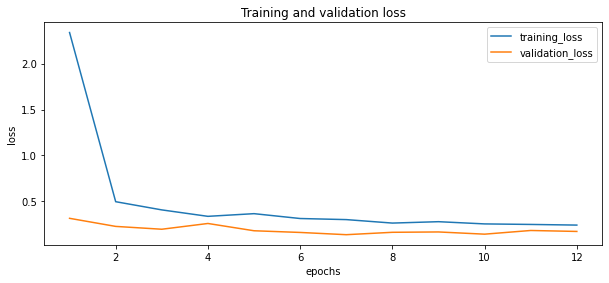

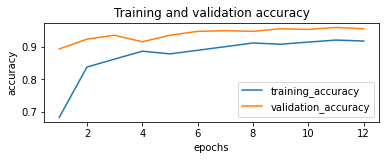

In [ ]:
plot_metrics(history.history, metrics = ['loss', 'accuracy'])

In [ ]:
# plt.savefig("output/plt1.jpeg")

### Estimating test accuracy

In [18]:
test_data_path = "/content/drive/MyDrive/Colab Notebooks/Project/Multi classifacation/Data/Test"

In [19]:
#loading the model
model = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/Project/Multi classifacation/inceptionV3_Multi_model.h5")

In [20]:
test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator = test_datagen.flow_from_directory(test_data_path,shuffle=False,
                                                              batch_size = 32,
                                                              class_mode = 'categorical',
                                                              target_size = (224, 224))

Found 500 images belonging to 10 classes.


In [21]:
model_evaluation = model.evaluate(test_generator)

16/16 [==============================] - 107s 7s/step - loss: 0.2037 - accuracy: 0.9440


In [22]:
print(dict(zip(model.metrics_names, model_evaluation)))

{'loss': 0.2036573886871338, 'accuracy': 0.9440000057220459}


### Predictions

In [23]:
predictions = model.predict(test_generator)

16/16 [==============================] - 55s 3s/step


In [24]:
predictions[:10]

array([[9.9354935e-01, 1.6711286e-06, 1.2216030e-13, 4.0837650e-10,
        3.4849375e-06, 6.4440658e-03, 1.4585771e-06, 9.3827668e-11,
        1.6218529e-13, 1.8887210e-09],
       [9.9278319e-01, 1.7404622e-04, 1.4747491e-06, 1.4096081e-09,
        1.2959647e-08, 2.6374482e-07, 5.8999113e-03, 1.1410915e-03,
        1.6114247e-11, 4.2132919e-09],
       [9.9999744e-01, 1.2481812e-06, 3.3204155e-11, 3.4689607e-09,
        1.4030091e-10, 3.9824815e-09, 4.2428323e-07, 8.2658897e-07,
        1.1208812e-13, 5.5997614e-08],
       [9.9999386e-01, 4.4636222e-06, 8.9622858e-11, 2.4050609e-10,
        1.6480825e-11, 2.7598190e-07, 1.0718907e-06, 9.7276676e-08,
        2.0488588e-11, 1.0403014e-07],
       [2.6790725e-04, 9.9861711e-01, 7.0947123e-11, 3.0788328e-08,
        1.4748493e-05, 1.0023845e-03, 2.9942770e-05, 2.9566112e-05,
        7.5671046e-11, 3.8172246e-05],
       [9.9985957e-01, 6.9161183e-06, 4.2370257e-06, 4.8133185e-08,
        3.7463525e-07, 1.5301732e-05, 8.2992032e-05, 1.99

In [25]:
predictions = np.argmax(predictions, axis=1)

In [26]:
predictions

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 7, 0, 0,
       0, 0, 0, 0, 0, 0, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 7, 6, 1, 1, 7, 2, 2, 2, 2, 2, 2, 6, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 7, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 8, 1, 2, 2, 2, 2, 6, 2, 2, 2, 2, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8,
       8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 0, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 0, 5, 5, 5, 5, 5, 5, 6,

In [27]:
cm = confusion_matrix(test_generator.labels, predictions)

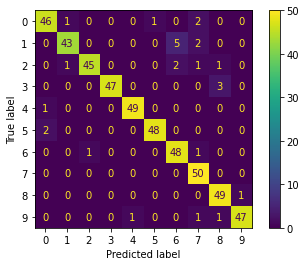

In [28]:
ConfusionMatrixDisplay.from_predictions(test_generator.labels, predictions)

In [33]:
cr = classification_report(test_generator.labels, predictions, labels=[0,1,2,3,4,5,6,7,8,9])

In [ ]:
#0:"dog", 1:"horse", 2:"elephant", 3:"butterfly", 4:"chicken", 5:"cat", 6:"cow", 7:"sheep", 8:"spider", 9:"squirrel"

In [34]:
print(cr)

              precision    recall  f1-score   support

           0       0.94      0.92      0.93        50
           1       0.96      0.86      0.91        50
           2       0.98      0.90      0.94        50
           3       1.00      0.94      0.97        50
           4       0.98      0.98      0.98        50
           5       0.98      0.96      0.97        50
           6       0.87      0.96      0.91        50
           7       0.88      1.00      0.93        50
           8       0.91      0.98      0.94        50
           9       0.98      0.94      0.96        50

    accuracy                           0.94       500
   macro avg       0.95      0.94      0.94       500
weighted avg       0.95      0.94      0.94       500



### Analyzing incorrect predictions

In [36]:
pred_vs_actuals_df = pd.DataFrame(data = {"actual_label":test_generator.labels,
                                          "pred_label":predictions.reshape(-1),
                                          "file":test_generator.filepaths})

In [37]:
pred_error_df = pred_vs_actuals_df[pred_vs_actuals_df.pred_label!=pred_vs_actuals_df.actual_label]
pred_error_df = pred_error_df.sample(5)
pred_error_df.reset_index(drop=False, inplace = True)

In [38]:
pred_error_df.sample()

,index,actual_label,pred_label,file
2,279,5,0,/content/drive/MyDrive/Colab Notebooks/Project...


ValueError: ignored

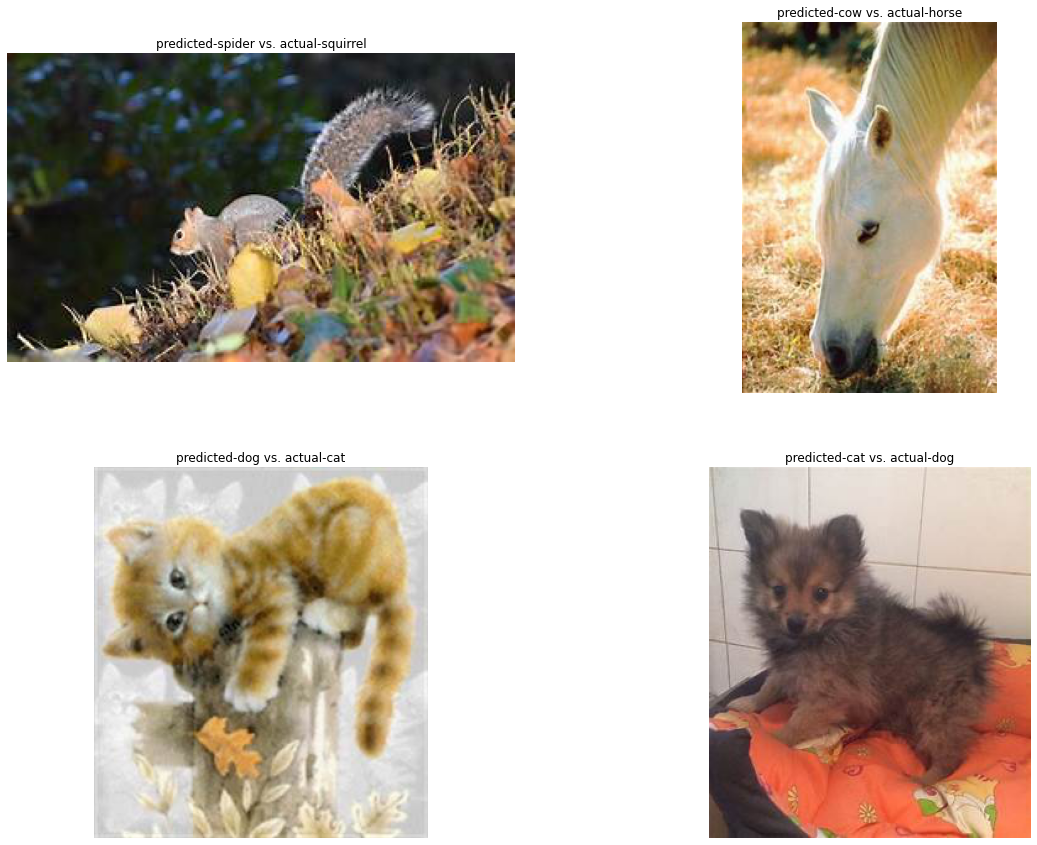

In [39]:
## visualizing incorrect predictions

label_mapping = {0:"dog", 1:"horse", 2:"elephant", 3:"butterfly", 4:"chicken", 5:"cat", 6:"cow", 7:"sheep", 8:"spider", 9:"squirrel"}

plt.figure(figsize=(20,15))


for i in range(pred_error_df.shape[0]):
  plt.subplot(int(pred_error_df.shape[0]/2),int(2), int(i + 1))
  plt.imshow(mpimg.imread(pred_error_df.iloc[i]['file']))
  plt.title("predicted-{} vs. actual-{}".format(label_mapping[pred_error_df.iloc[i]['pred_label']], label_mapping[pred_error_df.iloc[i]['actual_label']] ))
  plt.axis("off")